In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
import torch

In [ ]:
# @title Figure settings
from matplotlib import rcParams

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))

In [ ]:
# Take a single mouse (the sample notebook takes mouse 11, since it has some neurons from vis_ctx)
# The rest of this notebook will just focus on this mouse
dat = alldat[11]

In [ ]:
# Data is neurons x trials x time bins
dat["spks"].shape

(698, 340, 250)

In [ ]:
def get_successful_trials(dat): 
  """
  Drop the trials where the mouse failed to correctly distinguish the contrast 
  identification challenge.

  This returns the spike data on successful trials.

  TODO: might want to wrap this into a whole data cleaning function that returns 
  the cleaned dat dictionary object instead of just spikes.
  """
  result = np.zeros_like(dat["contrast_right"])
  mask1 = dat["contrast_right"] > dat["contrast_left"]
  mask2 = dat["contrast_left"] > dat["contrast_right"]
  result[mask1] = -1
  result[mask2] = 1

  success_idx = np.where(result == dat["response"])
  success_idx = np.squeeze(success_idx)

  return dat["spks"][:, success_idx, :]



In [ ]:
success_dat = get_successful_trials(dat)

In [ ]:
success_dat.shape

(698, 236, 250)

In [ ]:
dat["ccf"]

array([[9069.9, 1103.5, 3854.3],
       [8919.6, 1380.7, 3799.6],
       [9096.6, 1034.3, 3898.1],
       ...,
       [7338.8,  477.3, 4027.2],
       [7073.6, 1361. , 4292.5],
       [6410.5, 3570.2, 4955.6]])

In [ ]:
from scipy.spatial.distance import cdist

# calculate pairwise Euclidean distances
distances = cdist(dat["ccf"], dat["ccf"], 'euclidean')

# print the distances
distances.shape

(698, 698)

In [ ]:
 q_alpha = np.quantile(distances, 0.05)

In [ ]:
 np.quantile(distances, 0.95)

6320.776924556031

In [ ]:
np.unique(dat['brain_area'])

array(['ACA', 'CA1', 'DG', 'LGd', 'LH', 'MD', 'MOs', 'PL', 'SUB', 'VISam',
       'VISp', 'root'], dtype='<U5')

In [ ]:
q_alpha = np.quantile(distances, 0.545)
adj_mat = np.zeros((698, 698))
for i in range(698):
  for j in range(698):
    adj_mat[i,j] = int(((dat['brain_area'][i] == dat['brain_area'][j]) or (distances[i,j] < q_alpha)) and (i != j))
G = nx.Graph(adj_mat)
nx.is_connected(G)

True

In [ ]:
adj_mat

array([[0., 1., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
import pandas as pd
DF = pd.DataFrame(adj_mat)
 
# save the dataframe as a csv file
DF.to_csv("steinmetz.csv", index=None)

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


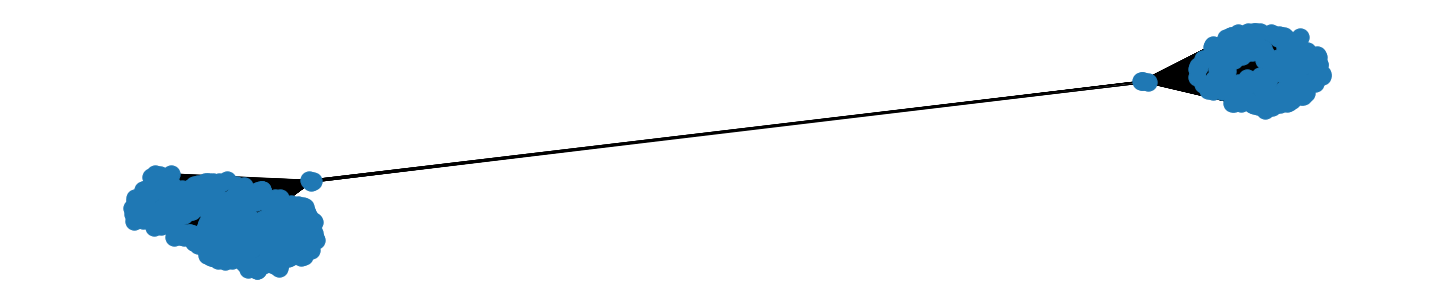

In [ ]:
pos = nx.spring_layout(G)

# Plot the graph using NetworkX and Matplotlib
nx.draw(G, pos=pos, with_labels=False)
plt.show()